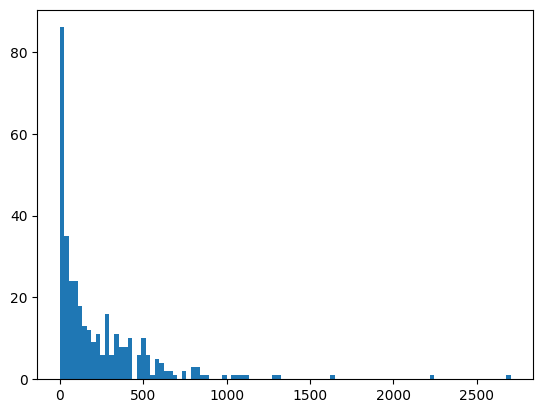

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from shapely.geometry import Point

import os
from google.colab import drive
drive.mount('/content/MyDrive/')

dir_path = '/content/MyDrive/MyDrive/City of Boston: Transit & Performance A/Data Files/'
files = files = os.listdir(dir_path)

pkl_path = "C:\\Users\\lou30\\Desktop\\学习\新\\CS506\\Project\\stop_info.pkl"


file_path = "C:\\Users\\lou30\\Desktop\\学习\新\\CS506\\Project\\202201-bluebikes-tripdata.csv"


bus_stop_info = pd.read_pickle(f"{dir_path}/stop_info.pkl")
df = pd.read_csv(f"{dir_path}/stop_info.pkl/deliverable_3_data/202201-bluebikes-tripdata.csv")


bus_stop_info['X'] = bus_stop_info['geometry'].apply(lambda geom: geom.x if geom is not None else None)
bus_stop_info['Y'] = bus_stop_info['geometry'].apply(lambda geom: geom.y if geom is not None else None)




start_station_info = df.groupby("start station id").agg(
    count=("start station longitude", "count"),
    longitude=("start station longitude", "first"),
    latitude=("start station latitude", "first")
).reset_index()

end_station_info = df.groupby("end station id").agg(
    count=("start station longitude", "count"),
    longitude=("start station longitude", "first"),
    latitude=("start station latitude", "first")
).reset_index()

plt.hist(start_station_info["count"],bins = 100)
plt.show()



In [57]:
def find_distance(lat1, lon1, lat2, lon2):
    '''
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Radius of the Earth in kilometers
    '''

    return np.sqrt((lat1-lat2)**2+(lon1-lon2)**2)


bus_stop_info["Count_Close_Start_Stations"] = 0  
bus_stop_info["Count_Close_End_Stations"] = 0

for bus_stop_index, bus_stop_row in bus_stop_info.iterrows():
    bus_stop_coords = (bus_stop_row["X"], bus_stop_row["Y"])
    count_start = 0
    
    for start_station_index, start_station_row in start_station_info.iterrows():
        start_station_coords = (start_station_row["longitude"], start_station_row["latitude"])
        distance = find_distance(*bus_stop_coords, *start_station_coords)

        if distance < 0.0045:
            count_start += 1

    count_end = 0
    
    for end_station_index, end_station_row in end_station_info.iterrows():
        
        end_station_coords = (end_station_row["longitude"], end_station_row["latitude"])
        distance = find_distance(*bus_stop_coords, *end_station_coords)
        
        if distance < 0.0045:
            count_end += 1
            
    bus_stop_info.at[bus_stop_index, "Count_Close_Start_Stations"] = count_start
    bus_stop_info.at[bus_stop_index, "Count_Close_End_Stations"] = count_end

print(bus_stop_info)

      stop_id   accuracy                    geometry          X          Y  \
0        1001  95.000000  POINT (-71.16955 42.30763) -71.169548  42.307629   
1        3031  95.000000  POINT (-71.01118 42.26125) -71.011185  42.261251   
2       64002  85.000000                        None        NaN        NaN   
3        7214  84.166667  POINT (-70.94246 42.48399) -70.942465  42.483992   
4        7828  81.666667  POINT (-71.25864 42.34475) -71.258640  42.344749   
...       ...        ...                         ...        ...        ...   
1109     3476   0.000000  POINT (-71.02036 42.26495) -71.020357  42.264948   
1110      536   0.000000  POINT (-71.06532 42.28206) -71.065322  42.282063   
1111    26137   0.000000  POINT (-70.92967 42.47128) -70.929672  42.471279   
1112    85568   0.000000  POINT (-71.16693 42.27752) -71.166930  42.277517   
1113     3308   0.000000  POINT (-70.96368 42.25041) -70.963678  42.250405   

      Count_Close_Start_Stations  Count_Close_End_Stations  
0 

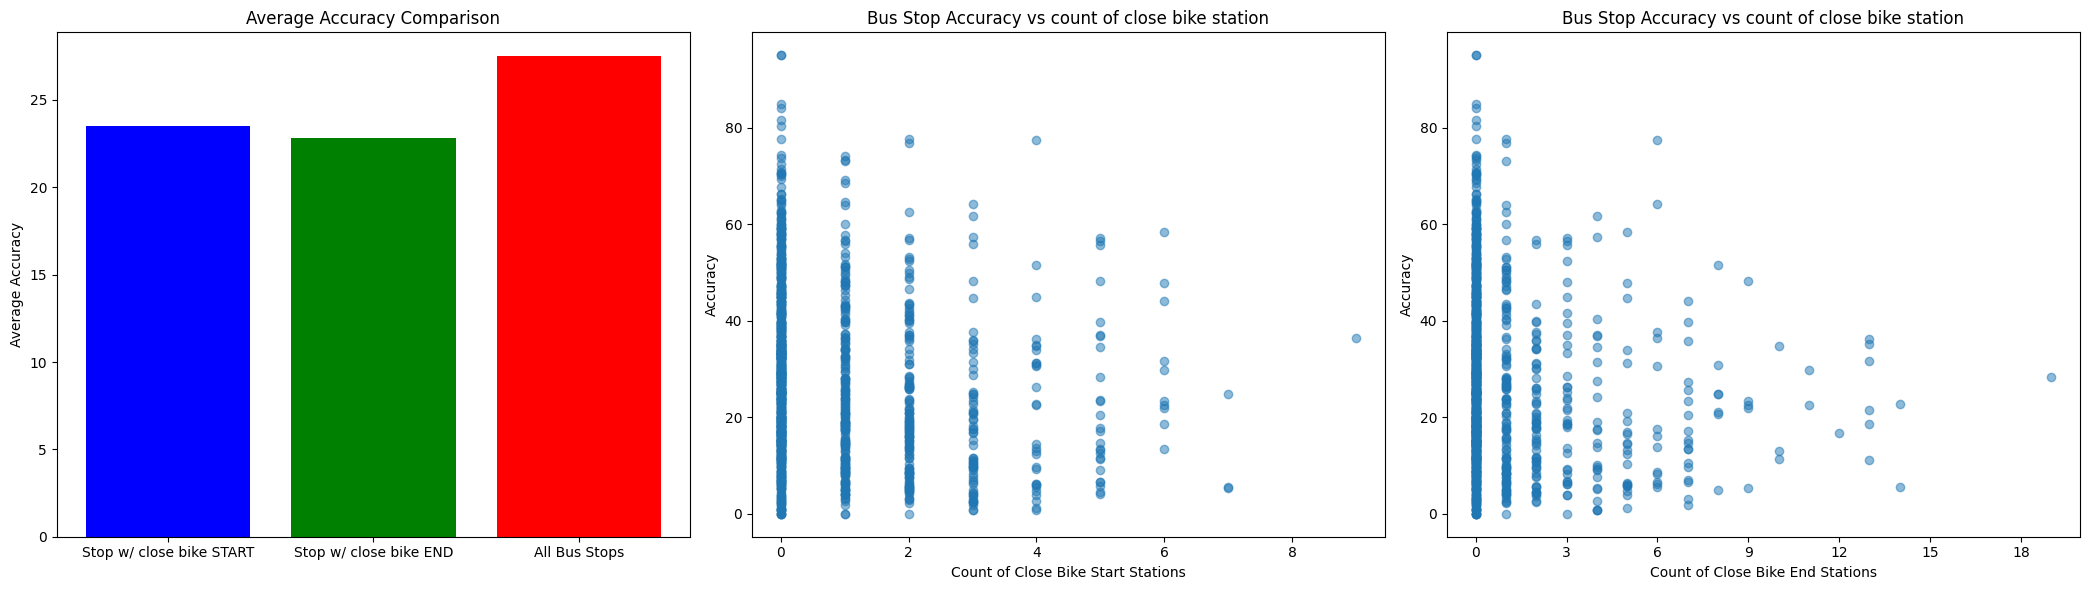

In [58]:


have_close_start_bike = bus_stop_info[bus_stop_info["Count_Close_Start_Stations"] > 0]
have_close_end_bike = bus_stop_info[bus_stop_info["Count_Close_End_Stations"] > 0]

avg_accuracy_end = have_close_end_bike["accuracy"].mean()
avg_accuracy_start = have_close_start_bike["accuracy"].mean()
avg_accuracy_all = bus_stop_info["accuracy"].mean()

fig, axs = plt.subplots(1, 3, figsize=(21, 6))

# First subplot - Bar Plot
axs[0].bar(["Stop w/ close bike START","Stop w/ close bike END", "All Bus Stops"], [avg_accuracy_start, avg_accuracy_end, avg_accuracy_all], color=['blue', 'green', "red"])
axs[0].set_title("Average Accuracy Comparison")
axs[0].set_ylabel("Average Accuracy")

# Second subplot - Scatter Plot
axs[1].scatter(bus_stop_info["Count_Close_Start_Stations"], bus_stop_info["accuracy"], alpha=0.5)
axs[1].set_title("Bus Stop Accuracy vs count of close bike station")
axs[1].set_xlabel("Count of Close Bike Start Stations")
axs[1].set_ylabel("Accuracy")

axs[2].scatter(bus_stop_info["Count_Close_End_Stations"], bus_stop_info["accuracy"], alpha=0.5)
axs[2].set_title("Bus Stop Accuracy vs count of close bike station")
axs[2].set_xlabel("Count of Close Bike End Stations")
axs[2].set_ylabel("Accuracy")
axs[2].xaxis.set_major_locator(MaxNLocator(integer=True))
# Adjust spacing between the subplots
plt.tight_layout()

# Show the plots
plt.show()

In [59]:

for bus_stop_index, bus_stop_row in bus_stop_info.iterrows():
    bus_stop_coords = (bus_stop_row["X"], bus_stop_row["Y"])

    bike_out_intensity = 0
    
    for start_station_index, start_station_row in start_station_info.iterrows():
        start_station_coords = (start_station_row["longitude"], start_station_row["latitude"])
        distance = find_distance(*bus_stop_coords, *start_station_coords)

        if distance < 0.0045:
            bike_out_intensity += start_station_row["count"]

    bike_in_intensity = 0
    
    for end_station_index, end_station_row in end_station_info.iterrows():
        
        end_station_coords = (end_station_row["longitude"], end_station_row["latitude"])
        distance = find_distance(*bus_stop_coords, *end_station_coords)
        
        if distance < 0.0045:
            bike_in_intensity += end_station_row["count"]
            
    bus_stop_info.at[bus_stop_index, "Intensity_Close_Start_Stations"] = bike_out_intensity
    bus_stop_info.at[bus_stop_index, "Intensity_Close_End_Stations"] = bike_in_intensity
    


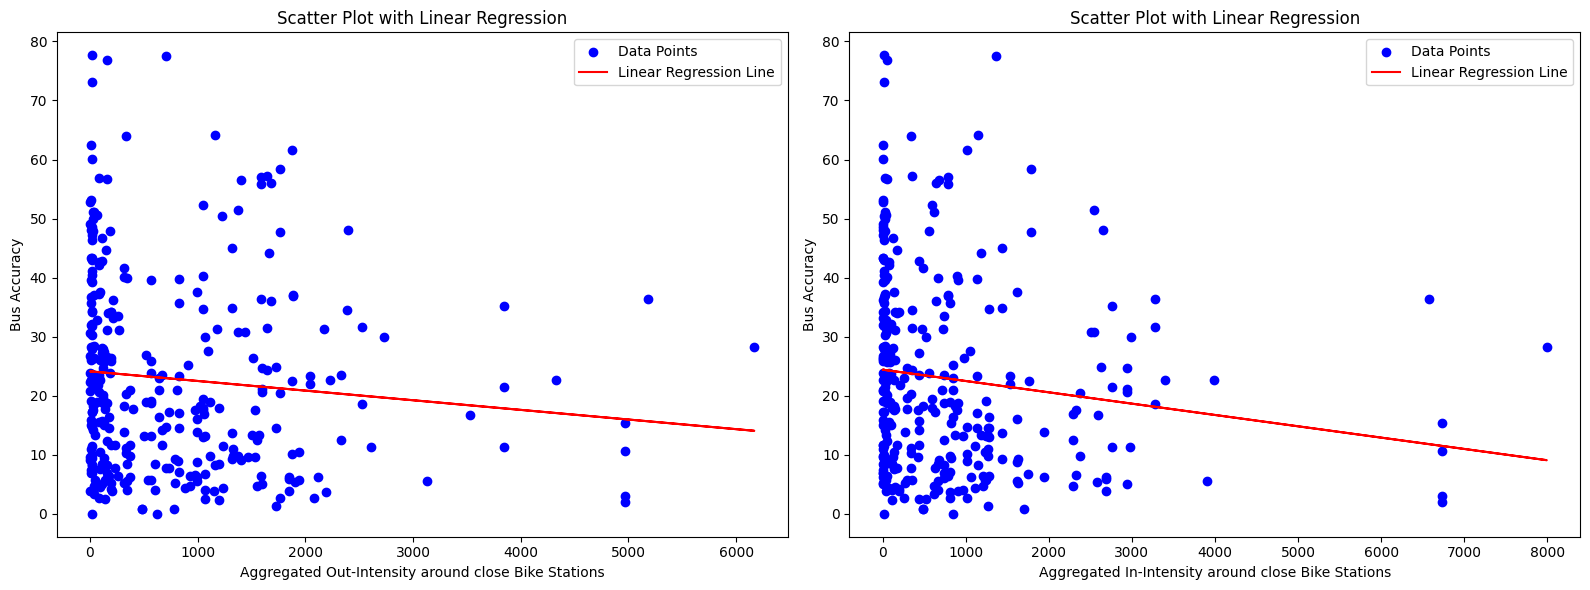

In [84]:
from sklearn.linear_model import LinearRegression
import seaborn as sns
import statsmodels.api as sm

bus_info_filtered = bus_stop_info[bus_stop_info["Intensity_Close_End_Stations"] > 0]


bus_info_filtered = bus_info_filtered[bus_info_filtered["Intensity_Close_Start_Stations"] > 0]

X1 = bus_info_filtered["Intensity_Close_Start_Stations"]
Y1 = bus_info_filtered["accuracy"]

# Fit the linear regression model for the first plot
model1 = LinearRegression()
X1 = X1.values.reshape(-1, 1)
model1.fit(X1, Y1)
Y1_pred = model1.predict(X1)

# Define the X and Y for the second plot
X2 = bus_info_filtered["Intensity_Close_End_Stations"]
Y2 = bus_info_filtered["accuracy"]

# Fit the linear regression model for the second plot
model2 = LinearRegression()
X2 = X2.values.reshape(-1, 1)
model2.fit(X2, Y2)
Y2_pred = model2.predict(X2)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# First plot
ax1.scatter(X1, Y1, label='Data Points', color='blue')
ax1.plot(X1, Y1_pred, label='Linear Regression Line', color='red')
ax1.set_title("Scatter Plot with Linear Regression")
ax1.set_xlabel("Aggregated Out-Intensity around close Bike Stations")
ax1.set_ylabel("Bus Accuracy")
ax1.legend()

# Second plot
ax2.scatter(X2, Y2, label='Data Points', color='blue')
ax2.plot(X2, Y2_pred, label='Linear Regression Line', color='red')
ax2.set_title("Scatter Plot with Linear Regression")
ax2.set_xlabel("Aggregated In-Intensity around close Bike Stations")
ax2.set_ylabel("Bus Accuracy")
ax2.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the combined figure
plt.show()


In [83]:
X1 = bus_info_filtered["Intensity_Close_Start_Stations"]
X2 = bus_info_filtered["Intensity_Close_End_Stations"]
Y = bus_info_filtered["accuracy"]

# Create a DataFrame with the independent variables X1 and X2
X = pd.DataFrame({'X1': X1, 'X2': X2})

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Fit the linear model
model = sm.OLS(Y, X).fit()

# Get the model summary
model_summary = model.summary()

# Print the model summary
print(model_summary)

                            OLS Regression Results                            
Dep. Variable:               accuracy   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     3.471
Date:                Wed, 06 Dec 2023   Prob (F-statistic):             0.0323
Time:                        18:20:50   Log-Likelihood:                -1341.3
No. Observations:                 319   AIC:                             2689.
Df Residuals:                     316   BIC:                             2700.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         24.1478      1.167     20.695      0.0